**Goal: Detect different landmines on a video.**  
Achieved: Some sort of classifier. I don't have time now to finish what I want but I'll do this later anyway)  

I created a small dataset for 3 landmine types. It has images with different aspect ratios. I resized and padded them to use squared images for the network training.  
I sed grayscaled images because rgb info isn't necessary for my case.

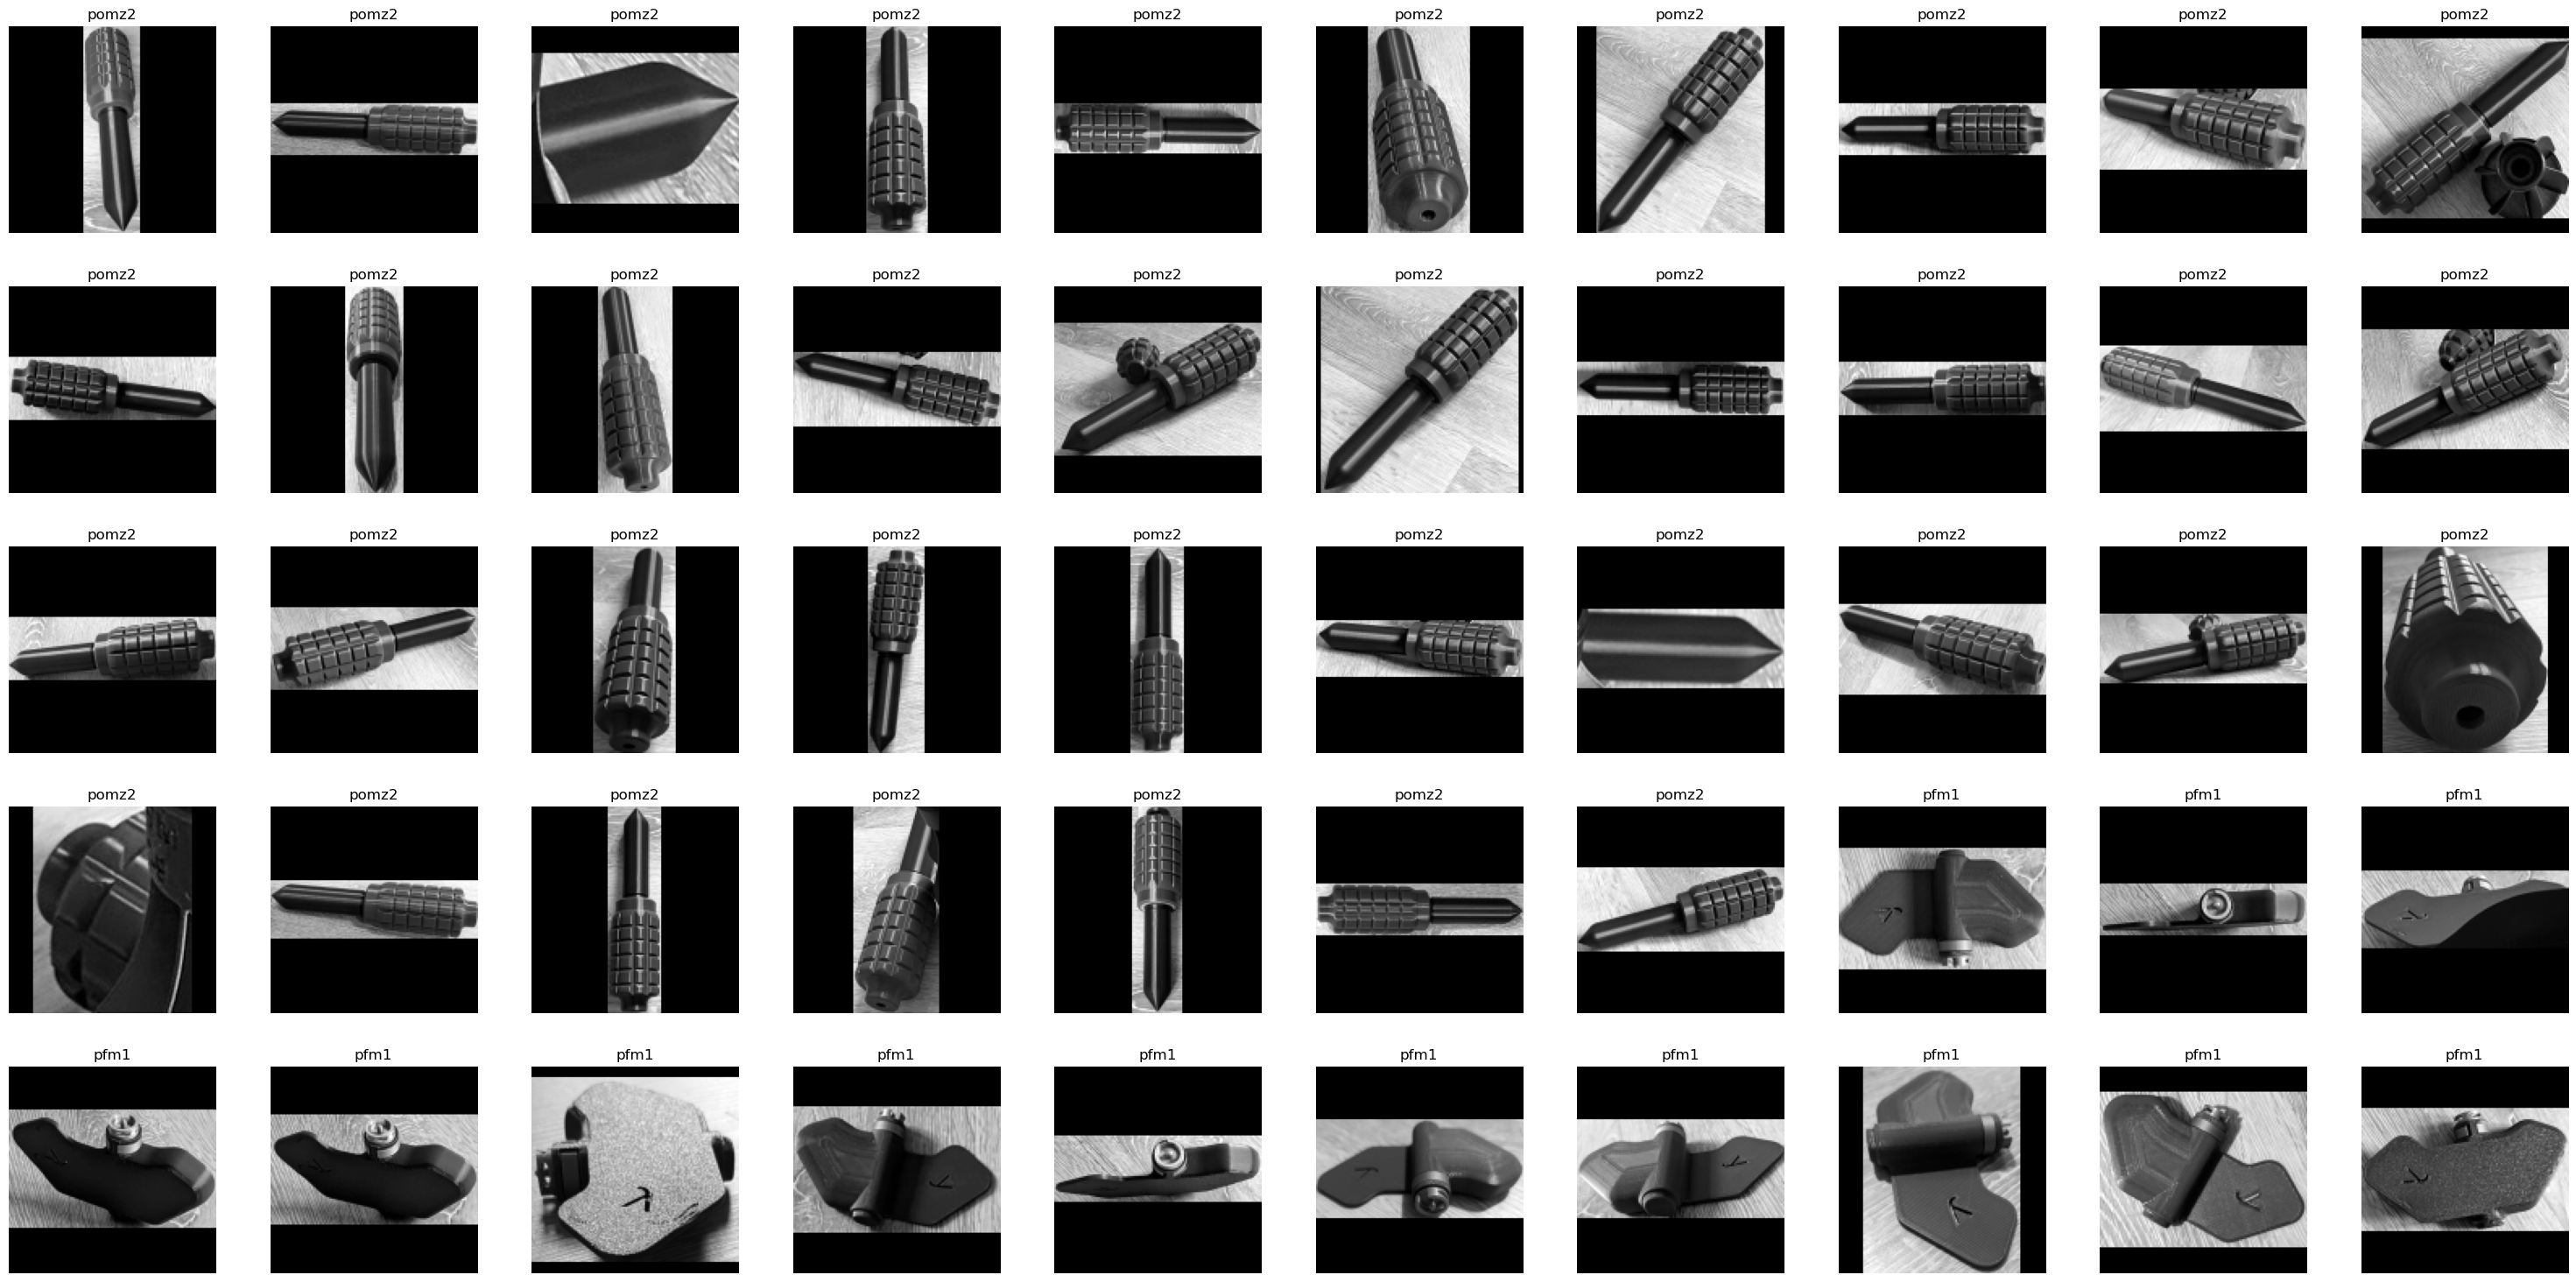

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import math

# Set the seeds for reproducibility
from numpy.random import seed
from tensorflow.random import set_seed
seed_value = 1234578790
seed(seed_value)
set_seed(seed_value)

# Paths
dataset_path = 'dataset'

# Initialize arrays for images and labels
images = []
labels = []
label_map = {}

# Define the target size for resizing images
target_size = (128, 128)

# Function to resize and pad images
def resize_and_pad(image, target_size, pad_color=0):
    h, w = image.shape[:3]
    sh, sw = target_size

    # Interpolations methods
    if h > sh or w > sw:  # shrinking image
        interp = cv2.INTER_AREA
    else:  # stretching image
        interp = cv2.INTER_CUBIC

    aspect = w / h  # aspect ratio

    # Compute scaling and pad sizes
    if aspect > 1:  # horizontal image
        new_w = sw
        new_h = np.round(new_w / aspect).astype(int)
        pad_vert = (sh - new_h) / 2
        pad_top, pad_bottom = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    else:  # vertical image
        new_h = sh
        new_w = np.round(new_h * aspect).astype(int)
        pad_horz = (sw - new_w) / 2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bottom = 0, 0

    # Resize image
    scaled_img = cv2.resize(image, (new_w, new_h), interpolation=interp)
    # Pad image
    padded_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bottom, pad_left, pad_right,
                                    borderType=cv2.BORDER_CONSTANT, value=[pad_color, pad_color, pad_color])

    return padded_img

# Read images and labels
for idx, object_type in enumerate(os.listdir(dataset_path)):
    object_path = os.path.join(dataset_path, object_type)
    if os.path.isdir(object_path):
        label_map[idx - 1] = object_type
        for img_name in os.listdir(object_path):
            if img_name.endswith(('jpg', 'jpeg', 'png')):
                img_path = os.path.join(object_path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    # Resize and pad the image
                    img = resize_and_pad(img, target_size)
                    images.append(img)
                    labels.append(idx - 1)

# Convert lists to numpy arrays
images = np.array(images, dtype=np.float32)
images = np.expand_dims(images, axis=-1) 
labels = np.array(labels)

# Function to display images
def plot_images(images, labels, label_map, num_images=15, images_per_row=5):
    num_rows = math.ceil(num_images / images_per_row)
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 3, num_rows * 3))
    fig.tight_layout()
    
    for i in range(num_images):
        row = i // images_per_row
        col = i % images_per_row
        ax = axes[row, col]
        ax.imshow(images[i], cmap='gray')
        ax.set_title(label_map[labels[i]])
        ax.axis('off')

    # Hide any remaining subplots
    for j in range(num_images, num_rows * images_per_row):
        row = j // images_per_row
        col = j % images_per_row
        fig.delaxes(axes[row, col])

    plt.show()

# Display the very start images from the dataset
plot_images(images / 255, labels, label_map, num_images=50, images_per_row=10)


**Let's split our dataset into train and validation sets.** 

In [3]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.3, random_state=42)

# Debugging. Printing unique labels and counts
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
unique_labels_val, counts_val = np.unique(y_val, return_counts=True)

print("Unique labels in y_train:", unique_labels_train)
print("Counts of each label in y_train:", counts_train)
print("Unique labels in y_val:", unique_labels_val)
print("Counts of each label in y_val:", counts_val)

# Normalize the pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0

# Ensure labels are in the range 0 to num_classes-1
num_classes = len(label_map)
print("Number of classes:", num_classes)
print(label_map)

# Convert labels to categorical format
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

Unique labels in y_train: [0 1 2]
Counts of each label in y_train: [24 28 26]
Unique labels in y_val: [0 1 2]
Counts of each label in y_val: [13 14  7]
Number of classes: 3
{0: 'pomz2', 1: 'pfm1', 2: 'f1'}


**CNN training**

I did lots of experiments and seems like this architecture is more or less ok.

In [4]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        MaxPooling2D((2, 2)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Get the input shape
input_shape = X_train.shape[1:]

# Create the model
model = create_cnn_model(input_shape, num_classes)

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_val, y_val))

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Epoch 1/20


2024-08-07 18:14:21.725436: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


5/5 [==============================] - 1s 65ms/step - loss: 1.0492 - accuracy: 0.4487 - val_loss: 0.9420 - val_accuracy: 0.5882
Epoch 2/20
5/5 [==============================] - 0s 48ms/step - loss: 0.9172 - accuracy: 0.6538 - val_loss: 0.8303 - val_accuracy: 0.5588
Epoch 3/20
5/5 [==============================] - 0s 41ms/step - loss: 0.7820 - accuracy: 0.6410 - val_loss: 0.7360 - val_accuracy: 0.7353
Epoch 4/20
5/5 [==============================] - 0s 40ms/step - loss: 0.7483 - accuracy: 0.6667 - val_loss: 0.6608 - val_accuracy: 0.7647
Epoch 5/20
5/5 [==============================] - 0s 39ms/step - loss: 0.6650 - accuracy: 0.7179 - val_loss: 0.6888 - val_accuracy: 0.7647
Epoch 6/20
5/5 [==============================] - 0s 40ms/step - loss: 0.6108 - accuracy: 0.7821 - val_loss: 0.5671 - val_accuracy: 0.7353
Epoch 7/20
5/5 [==============================] - 0s 41ms/step - loss: 0.5332 - accuracy: 0.7949 - val_loss: 0.6932 - val_accuracy: 0.7059
Epoch 8/20
5/5 [======================

**Testing trained network.**

Don't know why predictions so bad. Yes, I have an unbalanced dataset, and I tried balanced variant but it didn't help. So I'll look into this later.

In [7]:
def preprocess_image(image_path, target_size):
    # Load the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image
    image = resize_and_pad(image, target_size)
    # Normalize the image
    image = image / 255.0
    # Reshape the image to fit the model input
    image = np.expand_dims(image, axis=0)
    return image

test_images = [
  'test_pomz2_1.jpg',
  'test_pomz2_1 copy.jpg', # cropped images
  'test_pfm1_1.jpg',
  'test_pfm1_1 copy.jpg', # cropped image
  'test_f1_1.jpg',  
  'test_pomz2_2.jpg',
  'test_pfm1_2.jpg',
  'test_f1_2.jpg'
]      

for image_path in test_images:
    preprocessed_image = preprocess_image(image_path, target_size)
    predictions = model.predict(preprocessed_image)
    #print(predictions)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = label_map[predicted_class[0]]
    print(f'Image: {image_path}, Predicted Label: {predicted_label}')

1/1 [==============================] - 0s 11ms/step
Image: test_pomz2_1.jpg, Predicted Label: pfm1
1/1 [==============================] - 0s 11ms/step
Image: test_pomz2_1 copy.jpg, Predicted Label: pomz2
1/1 [==============================] - 0s 9ms/step
Image: test_pfm1_1.jpg, Predicted Label: pomz2
1/1 [==============================] - 0s 10ms/step
Image: test_pfm1_1 copy.jpg, Predicted Label: f1
1/1 [==============================] - 0s 10ms/step
Image: test_f1_1.jpg, Predicted Label: f1
1/1 [==============================] - 0s 10ms/step
Image: test_pomz2_2.jpg, Predicted Label: pfm1
1/1 [==============================] - 0s 10ms/step
Image: test_pfm1_2.jpg, Predicted Label: f1
1/1 [==============================] - 0s 10ms/step
Image: test_f1_2.jpg, Predicted Label: f1
